##preliminary activities

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/MyDrive/datasets/unbalanced_dataset_2304.zip"

replace unbalanced_dataset_2304/training/antelope/1d3c6105c9.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


#Dataset

In [ ]:
#dimensions for height, width and batch size
image_size = (224,224)
epochs = 10
batch_size = 32
data_dir = '/content/unbalanced_dataset_2304/training'

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=image_size,
  batch_size=batch_size)


val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=image_size,
  batch_size=batch_size)

Found 33004 files belonging to 101 classes.
Using 26404 files for training.
Found 33004 files belonging to 101 classes.
Using 6600 files for validation.


#model

In [ ]:
def get_model(image_size):
  base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False,weights='imagenet')
  base_model.trainable = False

  normalization_layer = layers.Rescaling(1./255)

  inputs = layers.Input(shape = image_size+ (3,), name='inputLayer')
  x = base_model(inputs, training = False)
  x = layers.GlobalAveragePooling2D(name='poolingLayer')(x)
  x = layers.Dropout(0.6)(x)
  x = layers.Dense(101, name='outputLayer')(x)
  outputs = layers.Activation(activation="softmax",  name='activationLayer')(x)

  model = tf.keras.Model(inputs, outputs, name = "FeatureExtractionModel")
  return model

In [ ]:
model = get_model(image_size)
model.summary()

Model: "FeatureExtractionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 poolingLayer (GlobalAverage  (None, 1280)             0         
 Pooling2D)                                                      
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 outputLayer (Dense)         (None, 101)               129381    
                                                                 
 activationLayer (Activation  (None, 101)              0         
 )                                          

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs=epochs,
  batch_size = 132
)

Epoch 1/10
826/826 [==============================] - 144s 154ms/step - loss: 1.2755 - accuracy: 0.7178 - val_loss: 0.5226 - val_accuracy: 0.8588
Epoch 2/10
826/826 [==============================] - 108s 130ms/step - loss: 0.5520 - accuracy: 0.8469 - val_loss: 0.4333 - val_accuracy: 0.8758
Epoch 3/10
826/826 [==============================] - 106s 128ms/step - loss: 0.4539 - accuracy: 0.8687 - val_loss: 0.4023 - val_accuracy: 0.8821
Epoch 4/10
826/826 [==============================] - 106s 127ms/step - loss: 0.4049 - accuracy: 0.8801 - val_loss: 0.3879 - val_accuracy: 0.8850
Epoch 5/10
826/826 [==============================] - 105s 127ms/step - loss: 0.3713 - accuracy: 0.8882 - val_loss: 0.3801 - val_accuracy: 0.8880
Epoch 6/10
826/826 [==============================] - 107s 128ms/step - loss: 0.3451 - accuracy: 0.8964 - val_loss: 0.3762 - val_accuracy: 0.8879
Epoch 7/10
826/826 [==============================] - 105s 127ms/step - loss: 0.3315 - accuracy: 0.8960 - val_loss: 0.3732 -

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

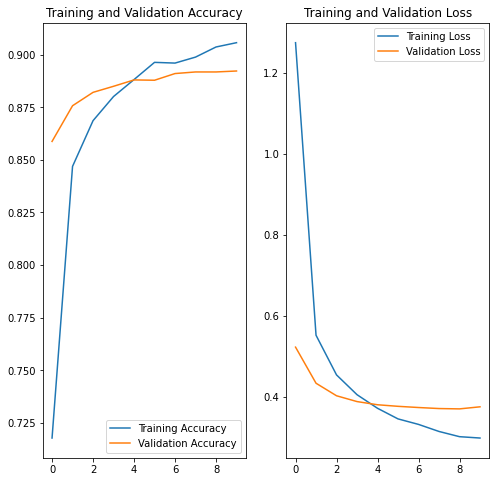

In [ ]:
plot_history(history)

# Evaluation

In [ ]:
features_extractor = Model(inputs=model.input, outputs=model.get_layer('activationLayer').output)

In [ ]:
import utils
GALLERY_PATH = "/content/gallery/"
QUERY_PATH = "/content/query/"

gallery = utils.Dataset(data_path=GALLERY_PATH).get_dataset()
query = utils.Dataset(data_path=QUERY_PATH).get_dataset()

In [ ]:
gallery_features, gallery_urls, gallery_labels = utils.compute_features(gallery, features_extractor)
query_features, query_urls, query_labels = utils.compute_features(query, features_extractor)
results = utils.compute_results(query_features, gallery_features, query_urls, gallery_urls)

In [ ]:
utils.evaluate(results, query_labels, gallery_labels)